_Version log: Branch of V19. Optimisation using MCMC Metropolis._

In [1]:
import sys, time
import numpy as np
import CS_functions as cs
from matplotlib import pyplot as plt
from scipy import fft as spfft
from tqdm import tqdm

plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [2]:
file_number = 15
file_name = "1dmockanderrors{:d}".format(file_number)
file_type = ".csv"
target, uncertainties = cs.open_dataset("1dmockanderrors{:d}".format(file_number), ".csv")
optlocs_file = "data\\" + file_name +"_optlocs.csv"

#training_dataset = 3
#training_interferograms, training_uncertainty = cs.open_training_dataset(training_dataset)
#optlocs_file = "data\\training_set{0:d}_optlocs.csv".format(training_dataset)

In [3]:
iterations = 20000
reduced_points = 12
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)
stepsize = 3
min_seperation = 1
subsampling_method= "regular"

In [4]:
#########INITAILISATION##########

start_time = time.time()

total_points = len(target)

detectors = cs.subsample_1d(total_points, reduced_points, subsampling_method)
detector_configerations = np.array(detectors)

score = cs.evaluate_score(detectors, target, uncertainties, regularization_coeffient)
scores = np.array([score])

#######START MCMC Metropolis###########
for n in tqdm(range(iterations)):
    steps = stepsize #reset steps
    new_detectors = detectors #reset detectors
    new_score = score #reset score

    while steps > 0:
        random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points

        current = new_detectors[random_detector]
        previous = -1 if random_detector == 0 else new_detectors[random_detector -1]
        next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]

        if previous +min_seperation < current and current < next -min_seperation:
            #detector has space to move forward or back.
            new_detectors[random_detector] += np.random.choice([-1,1])
            steps -= 1
        elif previous +min_seperation < current:
            #detector has space to move back.
            new_detectors[random_detector] -= 1
            steps -= 1
        elif current < next -min_seperation:
            #detector has space to move forward.
            new_detectors[random_detector] += 1
            steps -= 1
        else:
            #detector can't move.
            pass

    new_score = cs.evaluate_score(new_detectors, target, uncertainties, regularization_coeffient)
    acceptance = np.exp(score -new_score) # Normally MCMC uses `new_score /score` but I am looking for a minimum point so this scheme is better.

    detector_configerations = np.vstack((detector_configerations, new_detectors))

    if acceptance > np.random.rand():
        detectors = new_detectors
        score = new_score

    scores = np.append(scores, score)


###FINALISATION AFTER LOOP

best_iteration = np.argmin(scores)
detectors = detector_configerations[best_iteration]
score = scores[best_iteration]

end_time = time.time()
print(end_time - start_time)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [03:49<00:00, 87.22it/s] 

229.34658336639404


In [4]:
def MCMC_metropolis(reduced_points, target, uncertainty, regularization_coeffient =1e-3, subsampling_method= "regular", min_seperation= 1, iterations= 30000, stepsize= 31):

    total_points = len(target)

    detectors = cs.subsample_1d(total_points, reduced_points, subsampling_method)
    detector_configerations = np.array(detectors)

    score = cs.evaluate_score(detectors, target, uncertainty, regularization_coeffient)
    scores = np.array([score])

    #######START MCMC Metropolis###########
    for n in range(iterations):
        steps = stepsize #reset steps
        new_detectors = detectors #reset detectors
        new_score = score #reset score

        while steps > 0:
            random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points

            current = new_detectors[random_detector]
            previous = -1 if random_detector == 0 else new_detectors[random_detector -1]
            next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]

            if previous +min_seperation < current and current < next -min_seperation:
                #detector has space to move forward or back.
                new_detectors[random_detector] += np.random.choice([-1,1])
                steps -= 1
            elif previous +min_seperation < current:
                #detector has space to move back.
                new_detectors[random_detector] -= 1
                steps -= 1
            elif current < next -min_seperation:
                #detector has space to move forward.
                new_detectors[random_detector] += 1
                steps -= 1
            else:
                #detector can't move.
                pass

        new_score = cs.evaluate_score(new_detectors, target, uncertainty, regularization_coeffient)
        acceptance = np.exp(score -new_score) # Normally MCMC uses `new_score /score` but I am looking for a minimum point so this scheme is better.

        detector_configerations = np.vstack((detector_configerations, new_detectors))
        scores = np.append(scores, new_score)

        if acceptance > np.random.rand():
            detectors = new_detectors
            score = new_score


    ###FINALISATION AFTER LOOP

    best_iteration = np.argmin(scores)
    detectors = detector_configerations[best_iteration]
    score = scores[best_iteration]

    return detectors, score

detectors, score = cs.MCMC_metropolis(reduced_points, target, uncertainties, regularization_coeffient, "regular", iterations= 20000)

In [5]:
score

0.8541067862553774

In [6]:
###FINALISATION AFTER LOOP

samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient)

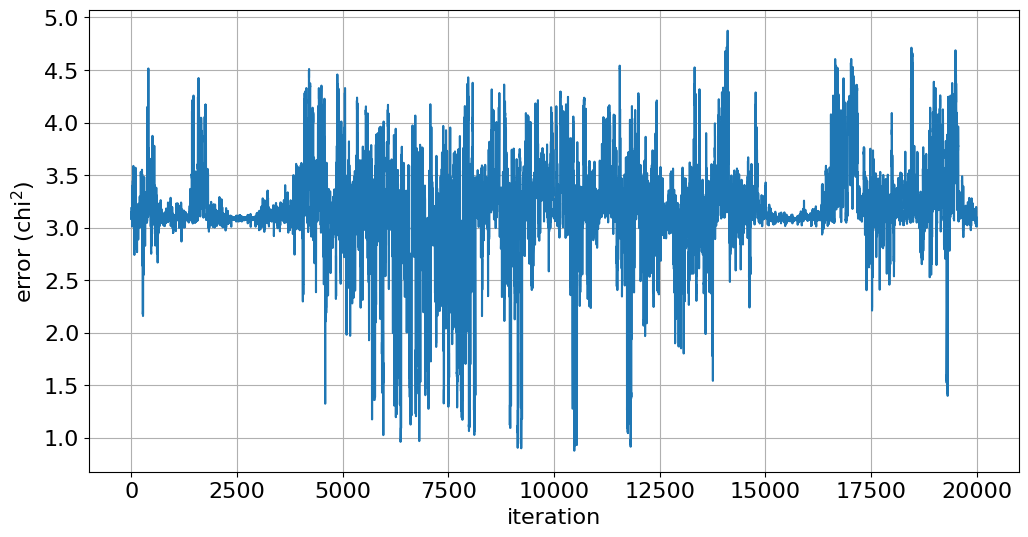

In [ ]:
fig, axs = plt.subplots(figsize= (12,6))

axs.plot(scores)
axs.grid(True)
axs.set(ylabel= "error (chi$^2$)", xlabel= "iteration")

plt.show()

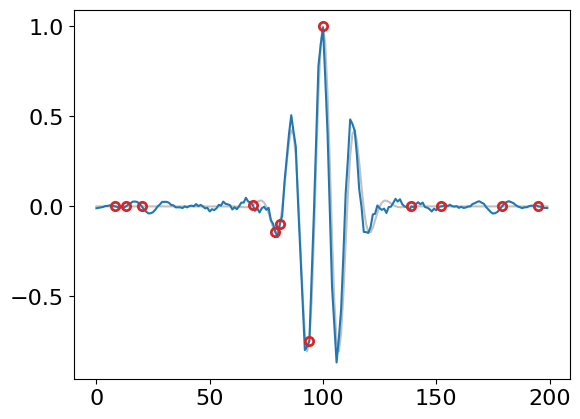

In [7]:
plt.plot(target, color= "silver")
plt.plot(result)
plt.plot(samples, marker= "o", linestyle= "none", markeredgecolor= "tab:red", markerfacecolor= "none", markeredgewidth= 2)
#plt.vlines(detector_configerations[0], ymin= 0, ymax= 1, linestyle= ":", color= "k", transform= plt.gca().get_xaxis_transform())
plt.show()

In [8]:
cs.evaluate_score(detectors, target, uncertainties, regularization_coeffient)

0.8541067862553774

In [9]:
cs.append_array_to_csv(detectors, optlocs_file)

print(*detectors, sep= ",")

8,13,20,69,79,81,94,100,139,152,179,195
